# ARIMA model building
Model building for ARIMA time series consists of three steps:

* Identification
* Estimation
* Diagnostic checking

Using bus ridership datasets, I assess stationarity, make a timseries stationary and assess the frequency components


In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.graphics.api import qqplot

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


Initially, I would like to visualize the data to understand what type of model should be used. 
For example, to understand is there an overall trend in the data? What about seasonality? 
If there isn’t a seasonal component in the data, then a regular ARIMA model can be used.

If there is too much variation to visually assess the trends, I can use autocorrelation and partial-autocorrelation functions (ACF) and (PCF) to investigate the seasonal components. Alternatively, the data can be re-sampled or a moving average used.


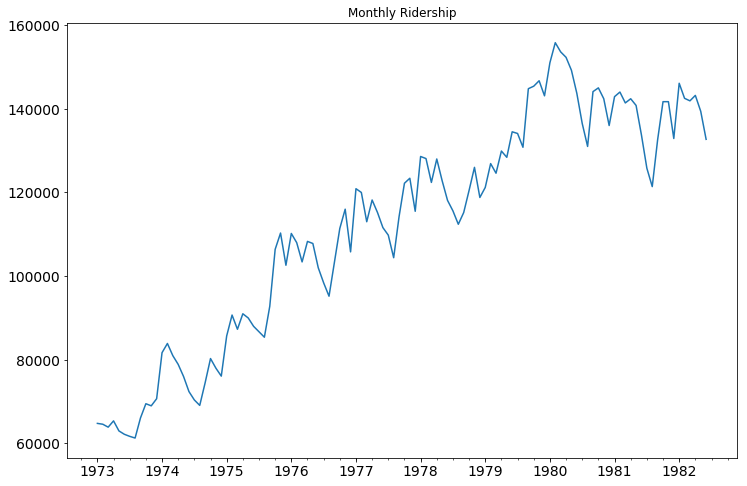

In [2]:
df = pd.read_csv('monthly_ridership.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)

start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)

df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
#or save the figure
#plt.savefig('month_ridership.png', bbox_inches='tight')

An important step before fitting an ARIMA function is to make sure the timeseries is stationary.
The following function tests for stationarity via the Durbin-Watson test.

Durbin-Waton (DW) statistic

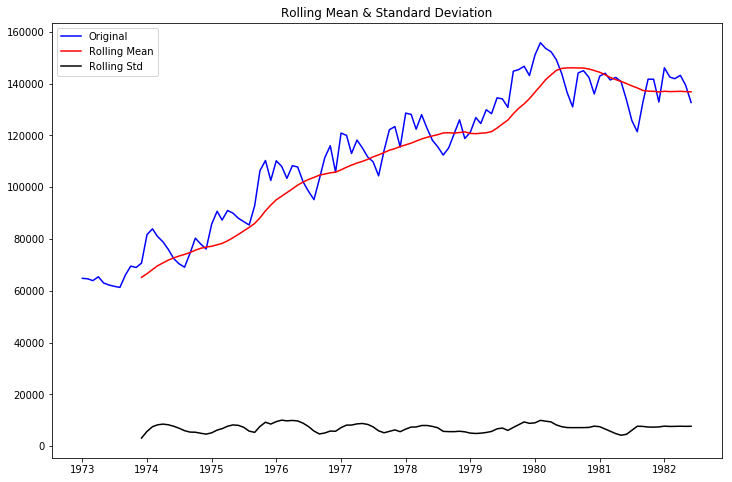

0.00242108517413


In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False, window=12).mean()
    rolstd = timeseries.rolling(center=False, window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Durbin Watson test:
    dfoutput=sm.stats.durbin_watson(timeseries)

    print(dfoutput)
    
test_stationarity(df.riders)


Initially, I would like to take a first difference of the data. 
This should help to eliminate the overall trend from the data.

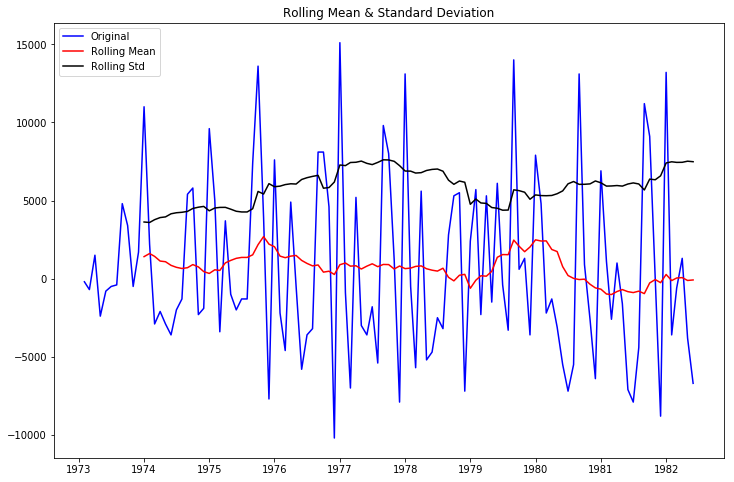

2.07854491301


In [6]:
df['first_difference'] = df.riders - df.riders.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

While this helped to improve the stationarity of the data it is not there yet (some seasonality is visible in the rolling mean). 
MY next step is to take a seasonal difference to remove the seasonality of the 
data and see how that impacts the stationarity of the data.

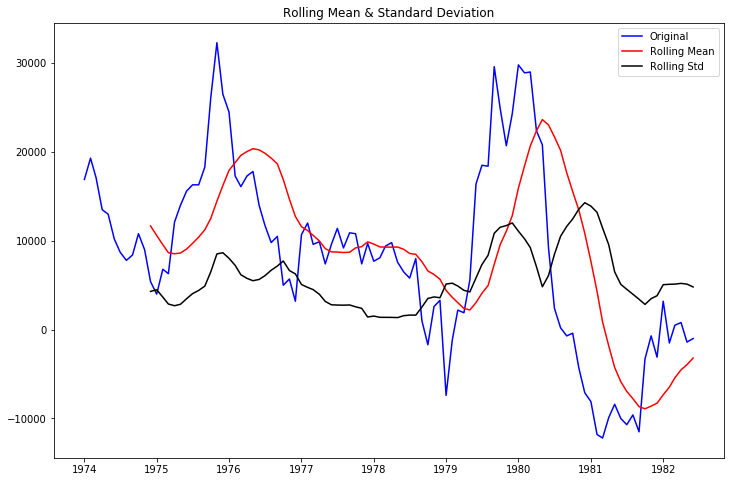

0.0829284532027


In [7]:
df['seasonal_difference'] = df.riders - df.riders.shift(12)  
test_stationarity(df.seasonal_difference.dropna(inplace=False))

Compared to the original data this is an improvement, but I am not there yet. 
The next step is to take a first difference of the seasonal difference.


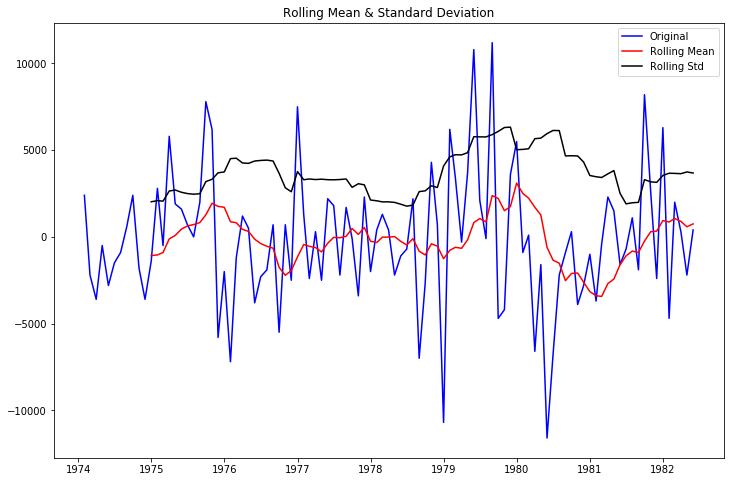

1.85351491104


In [8]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

Once stationarity is confirmed, the next step is to <i>identify</i> the model. 
Identification consists of specifying the appropriate structure (AR, MA or ARMA) and order
of the model.
This can be done by looking at plots of the acf and pacf.
Sometimes identification is done by an automated iterative procedure; fitting many different possible model structures and orders and using a goodness-of-fit statistic to select the best model.
<p>
Identification by visual inspection:
The classical method of model identification as described by Box and Jenkins is judge the appropriate model structure and order from the appearance of the plotted acf and pacf. 
<p>The acf at lag k measures the correlation of the series with itself lagged k time-points.
The pacf at lag k is the autocorrelation at lag k after first removing autocorrelation with a AR(k-1) model 



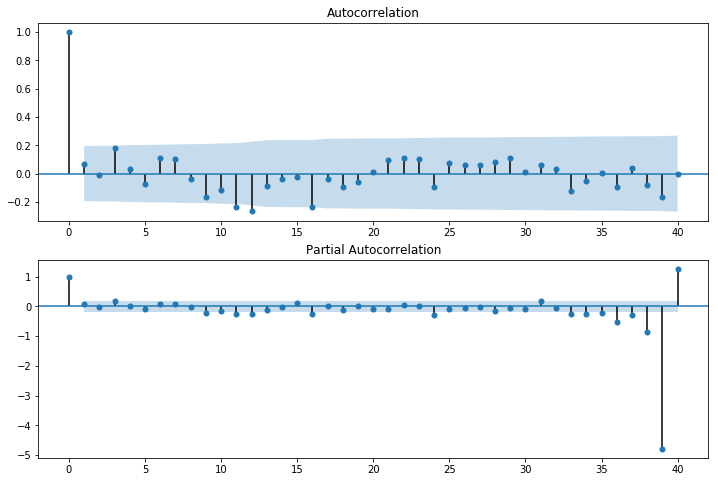

In [9]:
'''
Plot ACF and PCF for seasonal first differences 
(why points from the13th instance on are included).


'''
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)


Because the autocorrelation of the differenced series is negative at lag 12 
(one year later), I should add an MA term (1)
As well, trying out different terms, shows that an AR term improves the accuracy 
of the prediction for the next year. 

A thorough procedure would involve creating a function that fitted models using 
all possible combinations of the parameters, and use those models to predict the outcome 
for multiple time periods, and then select the model with the smallest sum of squared errors.

<p>
For now I can assume a model of order (1,1) (AR, MA)

In [10]:
#convert to float
new_riders=df.riders.astype(float)
results = sm.tsa.ARMA(new_riders,(1,1)).fit()


Forecasts:
Now that I have a model built, I can use it to make forecasts. This is fairly straightforward using the predict() attribute

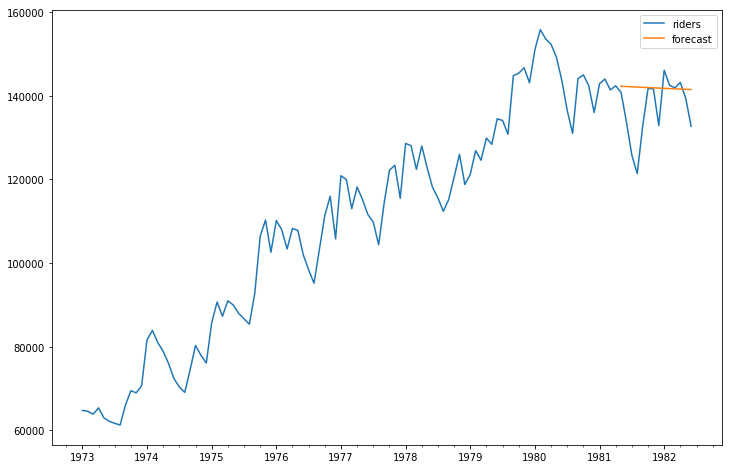

In [11]:
#predict on time periods we do have data for, to enable assessment of prediction performance
df['forecast'] = results.predict(start = 100, end= 114, dynamic= True)  
df[['riders', 'forecast']].plot(figsize=(12, 8))

Evaluation:
Assess the null hypothesis that the residuals come from a normal distribution. The autocorrelation of residuals should be zero, or they should be evenly distributed (can be viewed through a qq-plot).



NormaltestResult(statistic=134.65111791963747, pvalue=5.7660878213833085e-30)


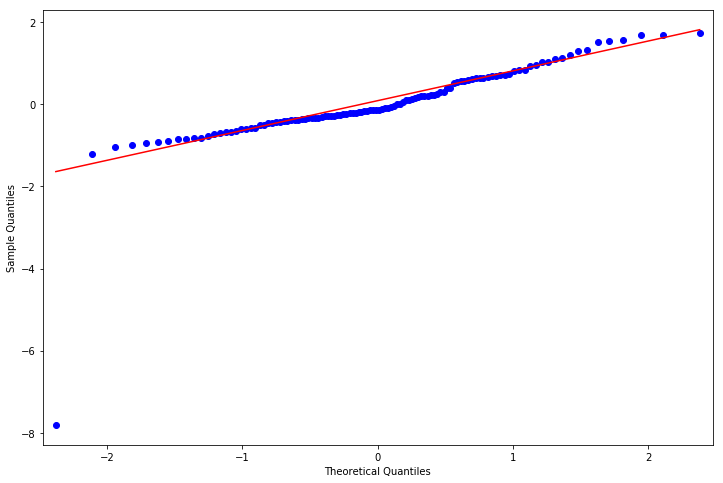

In [98]:
resid = results.resid
print(stats.normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)